# Data

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Get Kaggle Token by uploading to your drive
!cp '/content/drive/My Drive/Colab Notebooks/data/tokens/kaggle.json' kaggle.json

Mounted at /content/drive


In [ ]:
# Move the Token to .kaggle so Colab can use it
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Download data/info and put them in the train folder
# !kaggle competitions download -c 'painter-by-numbers' -f 'train_1.zip'
# !kaggle competitions download -c 'painter-by-numbers' -f 'train_2.zip'
# !kaggle competitions download -c 'painter-by-numbers' -f 'train_3.zip'
!kaggle competitions download -c 'painter-by-numbers' -f 'train_4.zip'
!kaggle competitions download -c 'painter-by-numbers' -f 'train_5.zip'
!kaggle competitions download -c 'painter-by-numbers' -f 'train_6.zip'
!kaggle competitions download -c 'painter-by-numbers' -f 'train_info.csv'

!unzip train_info.csv.zip -d train
# !unzip train_1.zip -d train
# !unzip train_2.zip -d train
# !unzip train_3.zip -d train
# !mv train/train_1/* train/
# !mv train/train_2/* train/
# !mv train/train_3/* train/

!unzip train_4.zip -d train
!rm train_4.zip

!unzip train_5.zip -d train
!rm train_5.zip

!unzip train_6.zip -d train
!rm train_6.zip

!mv train/train_4/* train/
!mv train/train_5/* train/
!mv train/train_6/* train/

!rm train_info.csv.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train_6/6418.jpg  
  inflating: train/train_6/64181.jpg  
  inflating: train/train_6/64182.jpg  
  inflating: train/train_6/64184.jpg  
  inflating: train/train_6/64186.jpg  
  inflating: train/train_6/64187.jpg  
  inflating: train/train_6/64188.jpg  
  inflating: train/train_6/64189.jpg  
  inflating: train/train_6/64190.jpg  
  inflating: train/train_6/64191.jpg  
  inflating: train/train_6/64193.jpg  
  inflating: train/train_6/64194.jpg  
  inflating: train/train_6/64195.jpg  
  inflating: train/train_6/64196.jpg  
  inflating: train/train_6/64197.jpg  
  inflating: train/train_6/64198.jpg  
  inflating: train/train_6/64199.jpg  
  inflating: train/train_6/642.jpg   
  inflating: train/train_6/64200.jpg  
  inflating: train/train_6/64202.jpg  
  inflating: train/train_6/64204.jpg  
  inflating: train/train_6/64205.jpg  
  inflating: train/train_6/64206.jpg  
  inflating: train/train_6/64207.jpg  
  inflating: tr

In [ ]:
import pandas as pd
import torch, os
import numpy as np
import torchvision.transforms as transforms

In [ ]:
from PIL import Image
from os import listdir
from PIL import ImageFile
from tqdm import tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

class KaggleDataset(torch.utils.data.Dataset):
  def __init__(self, folder = 'train', image_transform = None):
    self.image_transform = image_transform
    self.folder = folder
    self.images = []
    # Load JSON files
    self.train_info = pd.read_csv(f'train/train_info.csv')

    ## This would work if we had all files, but not when we have partial
    # self.img_filename = np.array(self.train_info['filename'])
    # self.img_title = np.array(self.train_info['title'])

    # This would work if we had partial data. Would also work with all files, but would be inefficient
    available_files = [f for f in listdir(folder)]
    filename = []
    img_title = []
    images = []
    for i in tqdm(range(len(available_files)),position=0, leave=True):
      file = available_files[i]
      if file.endswith(".jpg"):
        filename.append(file)
        img_path = os.path.join(self.folder, file)

        with open(img_path, 'rb') as f:
            img = Image.open(f)
            image = img.convert('RGB')
            if self.image_transform: image = self.image_transform(image)
            images.append(image)

        img_title.append(self.train_info.loc[self.train_info['filename'] == file]["title"].values[0])
    self.img_filename = np.array(filename)
    self.img_title = np.array(img_title)
    self.images = images 

  def __getitem__(self, index:int):

    title = self.img_title[index]
    image = self.images[index]

    return image, title

  def __len__(self):
    return len(self.img_filename)

#train_data = KaggleDataset()

Image is The Sleeping Gypsy 
Image size is 3x2902x4490


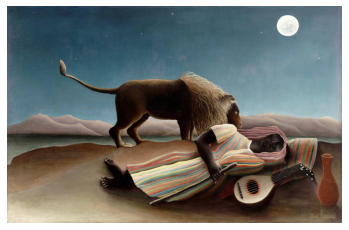

In [ ]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

image_index = 1
img, label = train_data[image_index]  # Returns image and label.

img = F.to_tensor(img)

print('Image is {0}'.format(label))
print('Image size is {0}x{1}x{2}'.format(img.shape[0], img.shape[1], img.shape[2]))

plt.figure()
plt.imshow(img.transpose(0,2).transpose(0,1));
plt.grid(False); plt.axis('off')
plt.show()

In [ ]:
image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

image_size = 64

transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])


# trainset = KaggleDataset(image_transform = image_transform)

trainset = KaggleDataset(image_transform = transform)

# GAN

Note: this section was taken from the GAN notebook to run the GAN model and then the captioner model, for outside resourse credation see that notebook.

In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
# 128x128
ngf = 128

# 64x64
# ngf = 64


# Size of feature maps in discriminator
# 128x128
ndf = 32

# 64x64
# ndf = 64

# Number of training epochs
num_epochs = 40

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

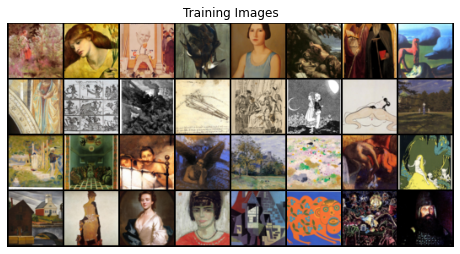

In [ ]:
import torchvision 

dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            ## 64x64
            # input is Z, going into a convolution
            # nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(ngf * 8),
            # nn.ReLU(True),

            ## 128x128
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            ##

            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )
    def forward(self, input):
        return self.main(input)


In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
import torch.optim as optim
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
print(len(trainset))

25756


In [ ]:
model_save_name = 'discriminater_40.pt'
path = F"/content/drive/My Drive/Colab Notebooks/data/model/{model_save_name}" 
#netD.load_state_dict(torch.load(path))

model_save_name = 'generator_40.pt'
path = F"/content/drive/My Drive/Colab Notebooks/data/model/{model_save_name}" 
#netG.load_state_dict(torch.load(path))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 10

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[1/10][0/805]	Loss_D: 1.6364	Loss_G: 5.6114	D(x): 0.5008	D(G(z)): 0.4528 / 0.0044
[1/10][50/805]	Loss_D: 0.5884	Loss_G: 22.1779	D(x): 0.6750	D(G(z)): 0.0000 / 0.0000
[1/10][100/805]	Loss_D: 0.2350	Loss_G: 11.7841	D(x): 0.8566	D(G(z)): 0.0000 / 0.0000
[1/10][150/805]	Loss_D: 0.4520	Loss_G: 11.9885	D(x): 0.7156	D(G(z)): 0.0002 / 0.0001
[1/10][200/805]	Loss_D: 0.5020	Loss_G: 4.2554	D(x): 0.8030	D(G(z)): 0.1826 / 0.0322
[1/10][250/805]	Loss_D: 0.7357	Loss_G: 2.8645	D(x): 0.5873	D(G(z)): 0.0942 / 0.0998
[1/10][300/805]	Loss_D: 0.1201	Loss_G: 6.2045	D(x): 0.9641	D(G(z)): 0.0778 / 0.0024
[1/10][350/805]	Loss_D: 0.1682	Loss_G: 4.0757	D(x): 0.8742	D(G(z)): 0.0152 / 0.0546
[1/10][400/805]	Loss_D: 0.3415	Loss_G: 3.5714	D(x): 0.7990	D(G(z)): 0.0718 / 0.0436
[1/10][450/805]	Loss_D: 0.1578	Loss_G: 8.6829	D(x): 0.9550	D(G(z)): 0.0911 / 0.0003
[1/10][500/805]	Loss_D: 0.2926	Loss_G: 3.4474	D(x): 0.8714	D(G(z)): 0.0666 / 0.0418
[1/10][550/805]	Loss_D: 0.6404	Loss_G: 3.3784	D(x)

In [ ]:

model_save_name = 'discriminater_123_40_456_20.pt'
path = F"/content/drive/My Drive/Colab Notebooks/data/model/{model_save_name}" 
 
torch.save(netD.state_dict(), path)

model_save_name = 'generator_123_40_456_20.pt'
path = F"/content/drive/My Drive/Colab Notebooks/data/model/{model_save_name}" 

torch.save(netG.state_dict(), path)

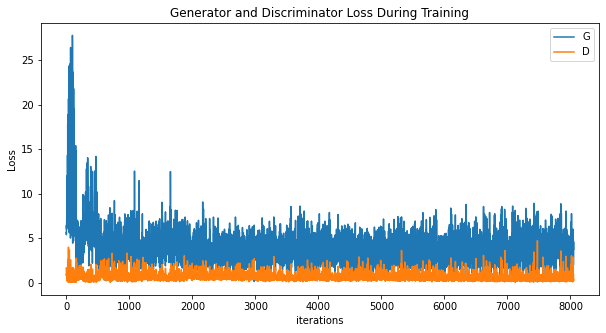

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

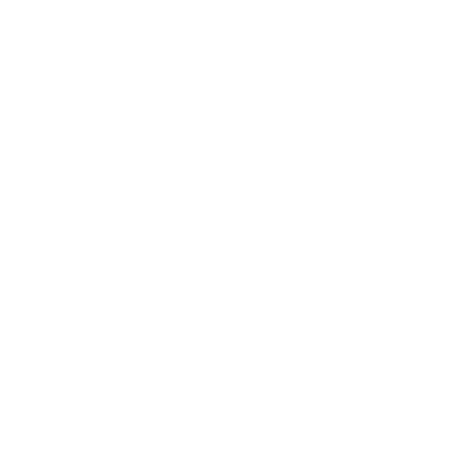

In [ ]:
import matplotlib.animation as animation
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)


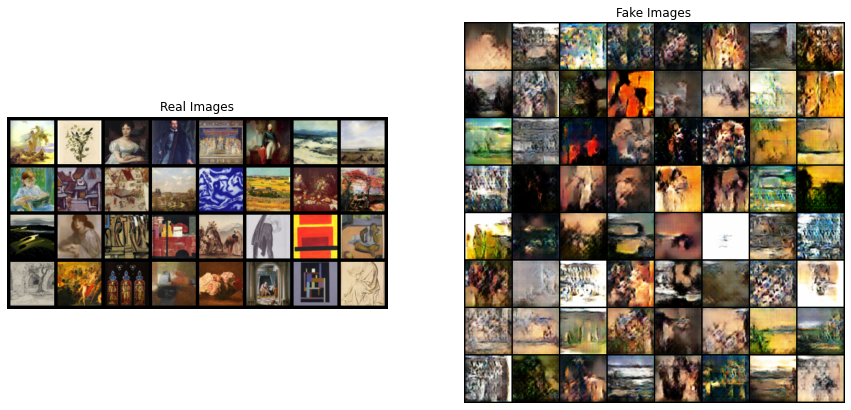

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

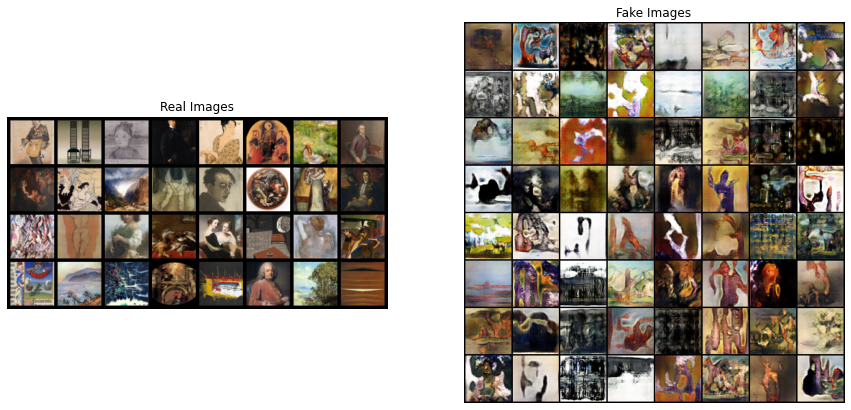

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

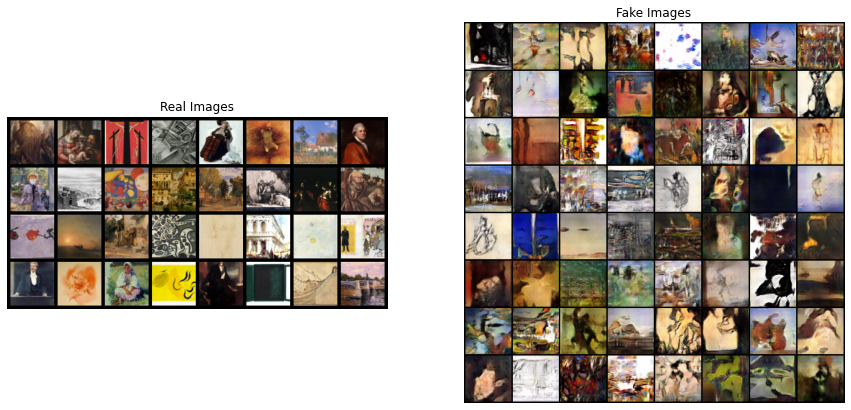

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

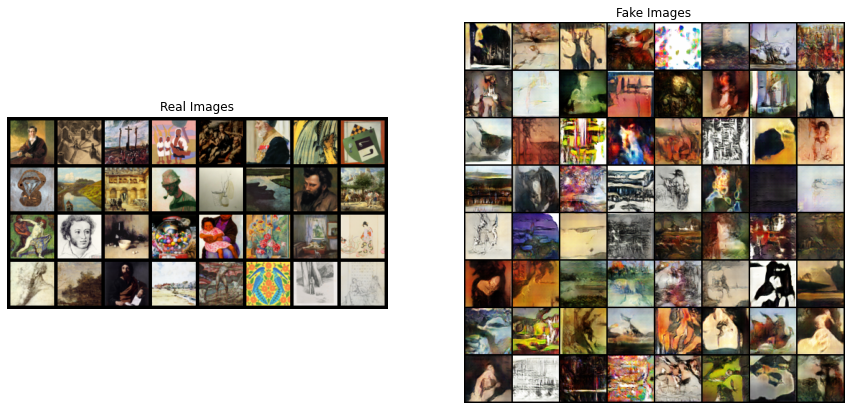

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Captioning

## Data

In [ ]:
import pandas as pd
import torch, os
import numpy as np
import torchvision.transforms as transforms

### Kaggle

In [ ]:
# Data download 
!kaggle competitions download -c 'painter-by-numbers' -f 'train_4.zip'
!unzip train_4.zip -d train
!mv train/train_4/* train/
!rm train_4.zip
!kaggle competitions download -c 'painter-by-numbers' -f 'train_5.zip'
!unzip train_5.zip -d train
!mv train/train_5/* train/
!rm train_5.zip
!kaggle competitions download -c 'painter-by-numbers' -f 'train_6.zip'
!unzip train_6.zip -d train
!mv train/train_6/* train/
!rm train_6.zip
!kaggle competitions download -c 'painter-by-numbers' -f 'train_info.csv'

!unzip train_info.csv.zip -d train
!rm train_info.csv.zip




import os
print(len(os.listdir('train')))

 51% 1.92G/3.76G [00:18<00:18, 110MB/s]
User cancelled operation
Archive:  train_4.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train_4.zip or
        train_4.zip.zip, and cannot find train_4.zip.ZIP, period.
mv: cannot stat 'train/train_4/*': No such file or directory
^C
^C
unzip:  cannot find or open train_5.zip, train_5.zip.zip or train_5.zip.ZIP.
mv: cannot stat 'train/train_5/*': No such file or directory
rm: cannot remove 'train_5.zip': No such file or directory
 33% 1.30G/3.89G [00:30<01:00, 46.1MB/s]
User cancelled operation
Archive:  train_6.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central direc

### MET

In [ ]:
pip install gdown


In [ ]:
!gdown https://drive.google.com/uc?id=1b-AU_9joqmTAzH-KyDgmbNqgKUXdv-UN
!gdown https://drive.google.com/uc?id=1cwV2kxPCaxSv-FSQSjIa8xYa-TO6gmP5
!gdown https://drive.google.com/uc?id=1JGKXQYAJcr6NjfNXNA_K76v2Bv10KV_Z
!gdown https://drive.google.com/uc?id=18lQJLfCfKZB-GU6u9sNM8_-BKx35bTMx

!unzip oils_small.zip -d train_MET
!unzip -q paintings_small.zip -d train_MET

Downloading...
From: https://drive.google.com/uc?id=1b-AU_9joqmTAzH-KyDgmbNqgKUXdv-UN
To: /content/oils_descrs.csv
3.47MB [00:00, 30.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cwV2kxPCaxSv-FSQSjIa8xYa-TO6gmP5
To: /content/oils_small.zip
405MB [00:03, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JGKXQYAJcr6NjfNXNA_K76v2Bv10KV_Z
To: /content/paintings_descrs.csv
7.93MB [00:00, 70.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=18lQJLfCfKZB-GU6u9sNM8_-BKx35bTMx
To: /content/paintings_small.zip
895MB [00:07, 126MB/s]
Archive:  oils_small.zip
   creating: train_MET/oils_small/
  inflating: train_MET/oils_small/10028.jpg  
  inflating: train_MET/oils_small/10035.jpg  
  inflating: train_MET/oils_small/10049.jpg  
  inflating: train_MET/oils_small/10061.jpg  
  inflating: train_MET/oils_small/10062.jpg  
 extracting: train_MET/oils_small/10063.jpg  
  inflating: train_MET/oils_small/10065.jpg  
 extracting: train_MET/oils_small/10066.jpg  
 extract

In [ ]:
!mv train_MET/oils_small/* train_MET/
!mv train_MET/paintings_small/* train_MET/
!rmdir train_MET/paintings_small/
!rmdir train_MET/oils_small/


In [ ]:
!pip install nltk

In [ ]:
from PIL import Image
import nltk
nltk.download('words')

class MetDataset(torch.utils.data.Dataset):
  def __init__(self, csvs, folder='paintings_small', image_transform=None):
    self.image_transform = image_transform
    self.folder = folder
    self.train_info = []
    self.img_filenames = []
    self.titles = []
    self.descriptions = []
    
    # to remove non-english words
    words = set(nltk.corpus.words.words())

    # Load JSON files
    
    for i in range(0,len(csvs)):
      other = pd.read_csv(csvs[i])
      self.train_info.append(other)

    available_files = [f for f in os.listdir(folder)]
    for file in available_files:
      for csv in self.train_info:
        #print(file[:-4])
        try:
          row = csv.loc[csv['Object ID'] == int(file[:-4])]
        except Exception as e:
          continue
        if row.empty or str(row['Title'].values[0]) == "nan":
          continue
        self.img_filenames.append(file)

        title = row['Title'].values[0]
        # to remove non-english words
        title = " ".join(w for w in nltk.wordpunct_tokenize(title) \
                if w.lower() in words or not w.isalpha())
        self.titles.append(title)
        self.descriptions.append(row['Description Paragraph'].values[0])
        break
    #img_title.append(self.train_info.loc[self.train_info['filename'] == file]["title"].values[0])

  def __getitem__(self, index:int):
    # Load images on the fly.
    filename = self.img_filenames[index]
    img_path = os.path.join(self.folder, filename)

    with open(img_path, 'rb') as f:
      img = Image.open(f)
      image = img.convert('RGB')

    title = self.titles[index]

    if self.image_transform: image = self.image_transform(image)

    return image, title

  def __len__(self):
    return len(self.img_filenames)



[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


### Validation Set

Take single directory and split into two train/val directories

In [ ]:
import shutil
import numpy as np

val_path = 'val_MET'
train_path = 'train_MET'

if not os.path.isdir(val_path):
  os.mkdir(val_path)

# Split images into validation/training/test sets
val_ratio = 0.15
test_ratio = 0.00 # no test set for now
root_dir = ''



# Creating partitions of the data after shuffeling
src = root_dir + train_path # Folder to copy images from

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])


train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in val_FileNames:
    shutil.copy(name, root_dir +val_path)

for name in test_FileNames:
    shutil.copy(name, root_dir +'test/' )


Total images:  6770
Training:  5754
Validation:  1016
Testing:  0


## Tokenizer

Goes through each dataset, adds top word_count words to bag of words representation. 

In [ ]:
from tqdm import tqdm
from collections import Counter 
class UniqueTokenizer():
  def __init__(self, datasets,word_count=20000):
    texts = ""
    for dataset in datasets:
      for i in tqdm(range(len(dataset.img_title)),position=0, leave=True):
        texts += dataset.img_title[i]
   
    word_counts = Counter(texts.lower().split(" "))
    word_counts = sorted(word_counts, key = word_counts.get, reverse = True)
    self.word2id = {w:i for (i, w) in enumerate(word_counts[:word_count])}
    self.word2id['<unk>'] = word_count
    self.word2id['<start>'] = word_count + 1
    self.word2id['<end>'] = word_count + 2
    self.word2id['<pad>'] = word_count + 3
    self.id2word = {i:w for (w, i) in self.word2id.items()}

  def tokenize(self, text):
      text = text.lower().split(" ")
      encoded_text = [self.word2id.get(w, self.word2id['<unk>']) for w in text]
      encoded_text = encoded_text[:254]
      encoded_text_array = np.ones(256) * self.word2id['<pad>']
      encoded_text_array[0] = self.word2id['<start>']
      encoded_text_array[1:len(encoded_text) + 1] = encoded_text
      encoded_text_array[len(encoded_text) + 1] = self.word2id['<end>']
      return torch.tensor(encoded_text_array, dtype = torch.long)

  def untokenize(self, tokens):
    return [self.id2word[token] for token in tokens.detach().numpy()]
  def __len__(self):
    return len(self.word2id)


In [ ]:
import random 

image_size=128
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                  std = [0.229, 0.224, 0.225])
        
train_transform = \
    transforms.Compose([transforms.Resize(image_size),
                       transforms.CenterCrop(image_size),
                        #transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        normalize])
val_transform = \
    transforms.Compose([transforms.Resize(image_size),
                        transforms.CenterCrop(image_size),
                        #transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        normalize])




In [ ]:
# MET data
paintings_train = MetDataset(['oils_descrs.csv','paintings_descrs.csv'], folder='train_MET/',image_transform = train_transform)
paintings_val = MetDataset(['oils_descrs.csv','paintings_descrs.csv'], folder='val_MET/',image_transform = val_transform)
train_data = paintings_train
val_data = paintings_val

METTokenizer =  UniqueTokenizer([paintings_train,paintings_val],word_count=5000)
print(len(paintings_train))

print(len(paintings_val))

print(len(METTokenizer))

100%|██████████| 755/755 [00:00<00:00, 894547.89it/s]

5031
755
5004


In [ ]:
# Kaggle Data
print("tokenizer done")
train_data = KaggleDataset(folder='train',image_transform = train_transform)
print("train done")
val_data = KaggleDataset(folder='val',image_transform = val_transform)
print("val done")


In [ ]:
kaggleTokenizer = UniqueTokenizer([kaggle_train_data,kaggle_val_data])


100%|██████████| 5778/5778 [00:01<00:00, 5303.60it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


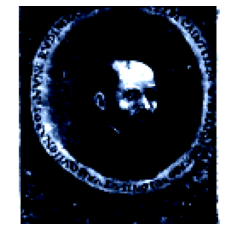

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Portrait of a Man
['<start>', 'portrait', 'of', 'a', 'man', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

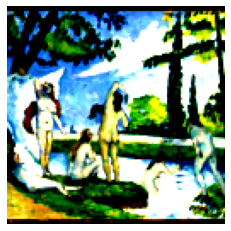


['<start>', '<unk>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [ ]:
import matplotlib.pyplot as plt

index = random.randint(0,10)
image, title = train_data[index]
plt.figure()
plt.imshow(np.transpose(image,(1,2,0)));
plt.grid(False); plt.axis('off')
plt.show()
print(title)
print(METTokenizer.untokenize(METTokenizer.tokenize(title)))

index = random.randint(0,10)
image, title = val_data[index]
plt.figure()
plt.imshow(np.transpose(image,(1,2,0)));
plt.grid(False); plt.axis('off')
plt.show()

print(title)
print(METTokenizer.untokenize(METTokenizer.tokenize(title)))


In [ ]:

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 16

text_traindataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
text_valdataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

print(next(iter(text_traindataloader))[0].shape)
print(next(iter(text_valdataloader))[0].shape)

# 32 images 3x64x64

torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])


## Captioner

The base code for this model is from assignment #3 of the Vision and Language class

### Encoder

In [ ]:
import torch.nn as nn
import torchvision.models as models

class ImageEncoder(nn.Module):
    # Encode images using Resnet-152
    def __init__(self, encoding_size: int):
        super(ImageEncoder, self).__init__()
        self.base_network = models.resnet152(pretrained = True)
        self.base_network.fc = nn.Linear(self.base_network.fc.in_features, encoding_size)
        self.bn = nn.BatchNorm1d(encoding_size, momentum=0.01)
        self.init_weights()
        self.dropout = nn.Dropout(p=0.3)

    def init_weights(self):
        
        self.base_network.fc.weight.data.normal_(0.0, 0.02)
        self.base_network.fc.bias.data.fill_(0)

    def forward(self, image):

        with torch.no_grad():

            x = self.base_network.conv1(image)
            x = self.base_network.bn1(x)
            x = self.base_network.relu(x)
            x = self.base_network.maxpool(x)
          
            x = self.dropout(self.base_network.layer1(x))
            x = self.dropout(self.base_network.layer2(x))
            x = self.dropout(self.base_network.layer3(x))
            x = self.dropout(self.base_network.layer4(x))
          
            x = self.base_network.avgpool(x)
            x = torch.flatten(x, 1)
  
        featureMap = self.base_network.fc(x)
        featureMap = self.bn(featureMap)
        return featureMap




### Decoder

In [ ]:
import torch.nn as nn
from torch.nn import functional as F

class TextDecoder(nn.Module):
    def __init__(self, input_size: int, state_size: int, vocab_size: int):
        super(TextDecoder, self).__init__()
        self.state_size = state_size
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.rnnCell = nn.LSTMCell(input_size, state_size, bias=True)
        self.predictionLayer = nn.Linear(state_size, vocab_size)
        self.init_weights()
        
    def dummy_input_state(self, batch_size):

        return (torch.zeros(batch_size, self.state_size), torch.zeros(batch_size, self.state_size))
    
    def init_weights(self):
        
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.predictionLayer.bias.data.fill_(0)
        self.predictionLayer.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, input_state, current_token_id):
        # Embed the input token id into a vector.
        embedded_token = self.embedding(current_token_id)

        # Pass the embedding through the RNN cell.
        h,c = self.rnnCell(embedded_token, input_state)
        
        # Output prediction.
        prediction = self.predictionLayer(F.relu(h))
        
        return prediction, (h,c)

### Full network

In [ ]:
!pip install pytorch-lightning

In [ ]:
import random 
import pytorch_lightning as pl

class ImageCaptioner(pl.LightningModule):
    def __init__(self, textTokenizer, val_data = None, embedding_size = 512, state_size = 1024):
        super(ImageCaptioner, self).__init__()
        self.vocabulary_size = len(textTokenizer)
        self.padding_token_id = textTokenizer.word2id["<pad>"]

        
        self.val_data = val_data
        
        
        # Create image encoder and text decoder.
        self.image_encoder = ImageEncoder(state_size)
        self.text_decoder = TextDecoder(embedding_size, 
                                        state_size, 
                                        self.vocabulary_size)
        
        self.criterion = nn.CrossEntropyLoss(
            ignore_index = self.padding_token_id)
        
        self.init_image_transforms()
        self.text_tokenizer = textTokenizer

        self.image_encoder_learning_rate = 1e-4
        self.text_decoder_learning_rate = 1e-3
    
    def init_image_transforms(self):
        # Create image transforms using standard Imagenet-based model transforms.
        normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                         std = [0.229, 0.224, 0.225])
        
        self.image_train_transform = \
            transforms.Compose([transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                normalize])
        
        self.image_test_transform = \
            transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize])

    # Predict text given image -- input text is for "teacher forcing" only.
    def forward(self, image, text, lengths, teacher_forcing = 1.0):
        # Keep output scores for tokens in a list.
        predicted_scores = list()
        
        # Encode the image.
        encoded_image = self.image_encoder(image)
        
        # Grab the first token in the sequence.
        start_token = text[:, 0]  # This should be the <start> symbol.
        # Predict the first token from the start token embedding 
        # and feed the image as the initial state.
        # let first input state = None
        token_scores, state = self.text_decoder((encoded_image,encoded_image), start_token)
        predicted_scores.append(token_scores)
        
        # Iterate as much as the longest sequence in the batch.
        # minus 1 because we already fed the first token above.
        # minus 1 because we don't need to feed the end token <end>.
        for i in range(0, max(lengths) - 2):
            if random.random() < teacher_forcing:
                current_token = text[:, i + 1]
            else:
                _, max_token = token_scores.max(dim = 1)
                current_token = max_token.detach() # No backprop.
            token_scores, state = self.text_decoder(state, current_token)
            predicted_scores.append(token_scores)
            
        # torch.stack(,1) forces batch_first = True on this output.
        return torch.stack(predicted_scores, 1), lengths

    def training_step(self, batch, batch_idx, optimizer_idx):
        images, texts = batch
        texts = [self.text_tokenizer.tokenize(text) for text in texts]
        lengths = torch.tensor([len(text) for text in texts]).cuda()
        texts = torch.stack(texts).cuda()
        
        # Compute the predicted texts.
        predicted_texts, _ = self(images, texts, lengths, 
                                  teacher_forcing = 1.0)
        
        # Define the target texts. 
        # We have to predict everything except the <start> token.
        target_texts =  texts[:, 1:].contiguous()

        # Use cross entropy loss.
        loss = self.criterion(predicted_texts.view(-1, self.vocabulary_size),
                              target_texts.view(-1))
        self.log('train_loss', loss, on_epoch = True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        images, texts = batch
        texts = [self.text_tokenizer.tokenize(text) for text in texts]
        lengths = torch.tensor([len(text) for text in texts]).cuda()
        texts = torch.stack(texts).cuda()

        predicted_texts, _ = self(images, texts, lengths,
                                  teacher_forcing = 0.0)
        
        target_texts = texts[:, 1:].contiguous()
        loss = self.criterion(predicted_texts.view(-1, self.vocabulary_size),
                              target_texts.view(-1))
        self.log('val_loss', loss, on_epoch = True)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        print('Validation loss %.2f' %  loss_mean)
        
        return {'val_loss': loss_mean}
    
    def training_epoch_end(self, outputs):
        
        loss_mean = torch.stack([x['loss'] for x in outputs[0]]).mean()
        print('Training loss %.2f' %  loss_mean)


    def configure_optimizers(self):
        return [torch.optim.SGD(list(self.image_encoder.base_network.fc.parameters())+\
                                list(self.image_encoder.bn.parameters()),
                                lr = self.image_encoder_learning_rate), \
                torch.optim.Adam(self.text_decoder.parameters(), 
                                 lr = self.text_decoder_learning_rate)], []
  


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Early stopping
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='min'
)

checkpoint_callback = ModelCheckpoint(
    filepath = '/content/drive/My Drive/Colab Notebooks/data/checkpoint/met_weights_{epoch:03d}-{val_loss:.2f}',
    verbose = True, monitor = 'val_loss', mode = 'min', save_top_k = 2)
#load_file = '/content/drive/My Drive/Colab Notebooks/data/checkpoint/image_captioner_weights_epoch=009-val_loss=9.28.ckpt'
# # Create image captioner.
image_captioner = ImageCaptioner(textTokenizer=METTokenizer)

print(image_captioner.vocabulary_size)
# ,embedding_size =  16, state_size = 64

#image_captioner.load_state_dict(torch.load(load_file)['state_dict'])# # Simple thanks to Pytorch Lighting.
trainer = pl.Trainer(gradient_clip_val = 1.0, gpus = 1, 
                     min_epochs = 1, max_epochs = 50,
                     checkpoint_callback = checkpoint_callback,
                     weights_summary = None) 
# Train the model.
trainer.fit(image_captioner, 
            train_dataloader = text_traindataloader,
            val_dataloaders = [text_valdataloader]) 

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory /content/drive/My Drive/Colab Notebooks/data/checkpoint exists and is not empty. With save_top_k=2, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


5004


Validation loss 8.53


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


Epoch 0: val_loss reached 4.74411 (best 4.74411), saving model to /content/drive/My Drive/Colab Notebooks/data/checkpoint/met_weights_epoch=000-val_loss=4.74.ckpt as top 2


Validation loss 4.74
Training loss 4.15


Epoch 1: val_loss reached 4.63249 (best 4.63249), saving model to /content/drive/My Drive/Colab Notebooks/data/checkpoint/met_weights_epoch=001-val_loss=4.63.ckpt as top 2


Validation loss 4.63
Training loss 3.09


Epoch 2: val_loss was not in top 2


Validation loss 4.95
Training loss 2.67


Epoch 3: val_loss was not in top 2


Validation loss 5.12
Training loss 2.34


Epoch 4: val_loss was not in top 2


Validation loss 5.46
Training loss 2.05


Epoch 5: val_loss was not in top 2


Validation loss 5.56
Training loss 1.79


Epoch 6: val_loss was not in top 2


Validation loss 5.83
Training loss 1.56


Epoch 7: val_loss was not in top 2


Validation loss 6.02
Training loss 1.37


Epoch 8: val_loss was not in top 2


Validation loss 6.23
Training loss 1.21


Epoch 9: val_loss was not in top 2


Validation loss 6.46
Training loss 1.09


Epoch 10: val_loss was not in top 2


Validation loss 6.39
Training loss 1.01


Epoch 11: val_loss was not in top 2


Validation loss 6.78
Training loss 0.93


Epoch 12: val_loss was not in top 2


Validation loss 7.09
Training loss 0.87


Epoch 13: val_loss was not in top 2


Validation loss 6.65
Training loss 0.83


Epoch 14: val_loss was not in top 2


Validation loss 6.82
Training loss 0.79


Epoch 15: val_loss was not in top 2


Validation loss 6.95
Training loss 0.76


Epoch 16: val_loss was not in top 2


Validation loss 7.13
Training loss 0.75


Epoch 17: val_loss was not in top 2


Validation loss 7.22
Training loss 0.71


Epoch 18: val_loss was not in top 2


Validation loss 7.18
Training loss 0.70


Epoch 19: val_loss was not in top 2


Validation loss 7.15
Training loss 0.67


Epoch 20: val_loss was not in top 2


Validation loss 7.13
Training loss 0.66


Epoch 21: val_loss was not in top 2


Validation loss 7.43
Training loss 0.64


Epoch 22: val_loss was not in top 2


Validation loss 7.28
Training loss 0.62


Epoch 23: val_loss was not in top 2


Validation loss 7.52
Training loss 0.61


Epoch 24: val_loss was not in top 2


Validation loss 7.52
Training loss 0.60


Epoch 25: val_loss was not in top 2


Validation loss 7.79
Training loss 0.60


Epoch 26: val_loss was not in top 2


Validation loss 8.17
Training loss 0.59


Epoch 27: val_loss was not in top 2


Validation loss 7.91
Training loss 0.57


Epoch 28: val_loss was not in top 2


Validation loss 7.83
Training loss 0.56


Epoch 29: val_loss was not in top 2


Validation loss 7.93
Training loss 0.55


Epoch 30: val_loss was not in top 2


Validation loss 7.78
Training loss 0.55


Epoch 31: val_loss was not in top 2


Validation loss 7.57
Training loss 0.55


Epoch 32: val_loss was not in top 2


Validation loss 7.62
Training loss 0.53


Epoch 33: val_loss was not in top 2


Validation loss 7.84
Training loss 0.53


Epoch 34: val_loss was not in top 2


Validation loss 8.05
Training loss 0.52


Epoch 35: val_loss was not in top 2


Validation loss 7.75
Training loss 0.51


Epoch 36: val_loss was not in top 2


Validation loss 8.42
Training loss 0.51


Epoch 37: val_loss was not in top 2


Validation loss 7.79
Training loss 0.51


Epoch 38: val_loss was not in top 2


Validation loss 7.73
Training loss 0.50


Epoch 39: val_loss was not in top 2


Validation loss 7.30
Training loss 0.49


Epoch 40: val_loss was not in top 2


Validation loss 7.57
Training loss 0.49


Epoch 41: val_loss was not in top 2


Validation loss 7.51
Training loss 0.49


Epoch 42: val_loss was not in top 2


Validation loss 7.66
Training loss 0.48


Epoch 43: val_loss was not in top 2


Validation loss 7.87
Training loss 0.48


Epoch 44: val_loss was not in top 2


Validation loss 7.84
Training loss 0.47


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Epoch 45: val_loss was not in top 2


1

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


## Save Model

In [ ]:
loss_name = '7.84'
path = f'/content/drive/My Drive/Colab Notebooks/data/model/met_captioner_weights_epoch=000-val_loss={loss_name}.ckpt'
torch.save(image_captioner.state_dict(), path)


In [ ]:
image,real_cap,_ = train_data[0]
print(image.shape)
loss_name = '9.28'
path = f'/content/drive/My Drive/Colab Notebooks/data/model/image_captioner_weights_epoch=000-val_loss={loss_name}.ckpt'
model = ImageCaptioner(textTokenizer = kaggleTokenizer)
model.load_state_dict(torch.load(path))
model.eval()

torch.Size([3, 64, 64])


ImageCaptioner(
  (image_encoder): ImageEncoder(
    (base_network): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

## Results

In [ ]:
import random

def generate_caption(model, image, max_length = 128):
  model.eval()

  #image = model.image_test_transform(image)
  max_length = torch.tensor([max_length])
  image = torch.unsqueeze(image,0)
  max_length = torch.unsqueeze(max_length,0)
  text=torch.tensor([[model.text_tokenizer.word2id["<start>"]]])

  scores, lengths = model(image=image, lengths=max_length, teacher_forcing=0,text=text)
  max_tokens = [score.max(dim = 1)[1] for score in scores]
  max_words = [model.text_tokenizer.id2word[token.item()] for token in max_tokens[0]]
  limited_words = []
  for i,word in enumerate(max_words):
    limited_words.append(word)
    if word == '<end>' or i == max_length:
      break

  return ' '.join(limited_words)

def getRandomImage(folder:str = "train",transform = None):
    available_files = listdir(folder)
    i =random.randint(0,len(available_files)-1)
    file = available_files[i]
    if file.endswith(".jpg"):
      img_path = os.path.join(folder, file)
      with open(img_path, 'rb') as f:
          img = Image.open(f)
          image = img.convert('RGB')
          if transform: image = transform(image)
          return image
    return None





True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


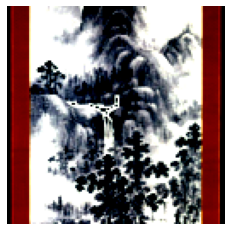

Real: | Mountain Stream on a Summer Day
Generated: | of the four <end>


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

tokenizer = METTokenizer
image, real_cap= train_data[random.randint(0,len(train_data))]
#image = getRandomImage("train",train_transform)

#real_cap = image_captioner.text_tokenizer.untokenize(real_cap)
captioner_file = f'/content/drive/My Drive/Colab Notebooks/data/model/met_captioner_weights_epoch=000-val_loss=7.84.ckpt'
print(os.path.exists(captioner_file))
captioner_model = ImageCaptioner(tokenizer)
captioner_model.load_state_dict(torch.load(captioner_file))
captioner_model.eval()

caption = generate_caption(captioner_model, image)

plt.figure()
plt.imshow(image.transpose(0,2).transpose(0,1));
plt.grid(False); plt.axis('off')
plt.show()
print('Real: {0}'.format(real_cap))

print('Generated: {0}'.format(caption))

In [ ]:
import torchvision

image_size=64
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                  std = [0.229, 0.224, 0.225])
        
test_transform = \
    transforms.Compose([transforms.ToPILImage(),
                        transforms.Resize(image_size),
                       transforms.CenterCrop(image_size),
                        transforms.ToTensor(),
                        normalize])

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

generator_file = "/content/drive/My Drive/kaggle_generator_128.pt"
netG = Generator(ngpu=1).to(device)
netG.load_state_dict(torch.load(generator_file))

num_fake = 25
fixed_noise = torch.randn(num_fake, nz, 1, 1, device=device)
netG.eval()
fake = netG(fixed_noise).detach().cpu()
print(fake.shape)

captioner_file = f'/content/drive/My Drive/Colab Notebooks/data/checkpoint/image_captioner_weights_epoch=009-val_loss=9.28.ckpt'
captioner_model = ImageCaptioner(kaggleTokenizer)
captioner_model.load_state_dict(torch.load(captioner_file)['state_dict'])
captioner_model.eval()

num_training = 1
for i in range(num_training):
  train_img,text = train_data[random.randint(0,len(train_data)-1)]
  plt.figure()
  plt.imshow(np.transpose(train_img,(1,2,0)))
  plt.show()
  print(f"Real: {text}")
  print(f"Fake: {generate_caption(captioner_model,train_img)}")

captions = [generate_caption(captioner_model,image) for image in fake]
print(captions)
i=0
for image,caption in zip(fake,captions):
  plt.figure()
  plt.imshow(np.transpose(image,(1,2,0)))
  plt.show()
  print(i,caption)
  i+=1


Output hidden; open in https://colab.research.google.com to view.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


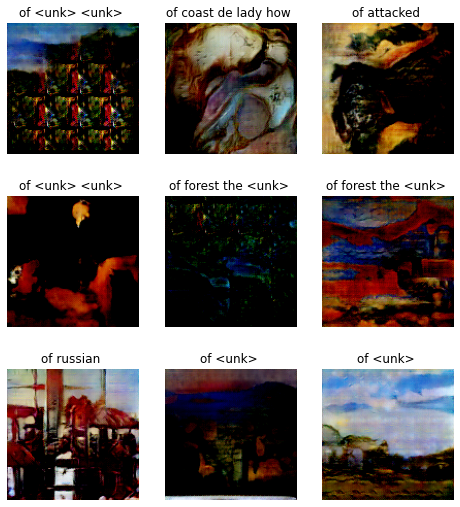

In [ ]:
# https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(8, 9))
columns = 3
rows = 3


# ax enables access to manipulate each of subplots
ax = []
img_idx = [0,1,4,6,13,21,17,22,23]
for i,j in enumerate(img_idx):
    img = np.transpose(fake[j],(1,2,0))
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(captions[j][:captions[j].index("<end>")])  # set title
    ax[-1].axis("off")
    #plt.xlabel(captions[j][:captions[j].index("<end>")])
    plt.imshow(img)


plt.show()  # finally, render the plot


## Data Saving

In [ ]:
pickle.dump( train_data, open( "/content/drive/My Drive/Colab Notebooks/data/train_data.p", "wb" ) )

pickle.dump( val_data, open( "/content/drive/My Drive/Colab Notebooks/data/val_data.p", "wb" ) )



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


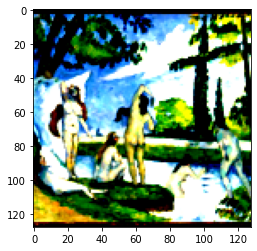

In [ ]:
import pickle

kaggle_train_data = pickle.load( open( "/content/drive/My Drive/Colab Notebooks/data/train_data.p", "rb" ) )
kaggle_val_data = pickle.load( open( "/content/drive/My Drive/Colab Notebooks/data/val_data.p", "rb" ) )
plt.imshow(np.transpose(val_data[i][0],(1,2,0)))
plt.show()